In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction 

This notebook offers demonstrations of different methods of querying data that is stored in BigQuery from within the JupyterLab interface of your Vertex AI Workbench instance.

Confused ? Let's define each of these terms in case they're new to you

 * **BigQuery** BigQuery is a fully managed, AI-ready data platform that helps you manage and analyze your data with built-in features like machine learning, search, geospatial analysis, and business intelligence. BigQuery's serverless architecture lets you use languages like SQL and Python to answer your organization's biggest questions with zero infrastructure management.
 
 * **JupyterLab**  JupyterLab is a highly extensible, feature-rich notebook authoring application and editing environment, and is a part of Project Jupyter, a large umbrella project centered around the goal of providing tools (and standards) for interactive computing with computational notebooks.
 
 * **Vertex AI Workbench instance** Vertex AI Workbench instances are Jupyter notebook-based development environments on Google Cloud for the entire data science workflow. Vertex AI Workbench instances are prepackaged with JupyterLab. Vertex AI Workbench instances have integrations and features can make it easier to access your data, process data faster, schedule notebook runs, and more.
 
For most of these methods, we will use a **Python JupyterLab Kernel**. In the Jupyter architecture, kernels are separate processes started by the server that run your code in different programming languages and environments.  We will use the IPython Jupyter Kernel that comes prepackaged with Vertex AI Workbench Instances. This will allow us to execute Python code in this notebook interactively.

Reference: 

https://cloud.google.com/bigquery/docs/introduction

https://jupyterlab.readthedocs.io/en/latest/user/interface.html

https://cloud.google.com/vertex-ai/docs/workbench/instances/introduction

https://jupyterlab.readthedocs.io/en/latest/user/documents_kernels.html#kernel-backed-documents

https://ipython.readthedocs.io/en/stable/index.html

## Method 1 : Using BigQuery Studio, to explore and preview data

BigQuery has public datasets which will be ananlyzing in this notebook.

In this method we will be using BigQuery Studio, a UI on Google Cloud, to get a sampe of records for these datasets.

Open BigQuery studio by clicking on this link https://console.cloud.google.com/bigquery

Explore the Google trends public dataset by followin these steps:

 * select project "bigquery-public-data"
   * select datatset "google_trends"
     * select table "international_top_terms"
       * click "preview" to see a sample of rows from this table




## Method 2 : Using the BigQuery Pane in Vertex AI workbnench
This is Method 1 of querying data that is stored in BigQuery from within the JupyterLab interface of your Vertex AI Workbench instance.

BigQuery is integrated into the the JupyterLab interface of your Vertex AI Workbench instance.

Through this integration you can use a BigQuery pane that lists available projects and datasets.

Let's use this BigQuery pane now to explore some BigQuery public datasets.

* select project "bigquery-public-data"
  * select datatset "google_trends"
    * select table "international_top_terms"
    * click "preview" to see a sample of rows from this table
    * click "query table" to open the Stand-alone BigQuery query editor opens as a separate tab in JupyterLab.

Reference :

https://cloud.google.com/vertex-ai/docs/workbench/instances/bigquery#browse_resources

https://cloud.google.com/vertex-ai/docs/workbench/instances/bigquery#stand-alone

## Method 3 : Using the %%bigquery magic command

This is Method 2 of querying data that is stored in BigQuery from within the JupyterLab interface of your Vertex AI Workbench instance.

For this method, it is required to use the IPython Jupyter Kernel that comes prepackaged with Vertex AI Workbench Instances. Please select & connect to it now.

The IPython Jupyter Kernel has a feature called "cell magics" which are handy commands built into the IPython kernel that make it easy to perform particular tasks.

BigQuery has developed "cell magics" to make it easy to execute SQL queries. There are two BigQuery "cell magics" 

1. %%bigquery

  *  Behind the scenes, the %%bigquery magic command uses the BigQuery client library for Python to run the given query
  *  Then convert the results to a pandas DataFrame 
  *  Then display results.

2. %%bigquery my_pandas_data_frame

  *  Behind the scenes, the %%bigquery magic command uses the BigQuery client library for Python to run the given query
  *  Then convert the results to a pandas DataFrame 
  *  Then save the pandas DataFrame to the variable my_pandas_data_frame
  
See exampe of these two "cell magics" below

Reference:

https://cloud.google.com/vertex-ai/docs/workbench/instances/bigquery#query_data_by_using_the_bigquery_magic_command

https://ipython.readthedocs.io/en/stable/interactive/magics.html#cell-magics

https://ipython.readthedocs.io/en/stable/interactive/magics.html#line-magics

https://cloud.google.com/python/docs/reference/bigquery/latest/magics


In [15]:
%%bigquery
SELECT
  country_code,
  country_name,
  COUNT(DISTINCT region_code) AS num_regions
FROM
  `bigquery-public-data.google_trends.international_top_terms`
WHERE
  refresh_date = DATE_SUB(CURRENT_DATE, INTERVAL 1 DAY)
GROUP BY
  country_code,
  country_name
ORDER BY
  num_regions DESC
  LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,country_code,country_name,num_regions
0,TR,Turkey,81
1,TH,Thailand,77
2,VN,Vietnam,63
3,JP,Japan,47
4,RO,Romania,42
5,NG,Nigeria,37
6,IN,India,36
7,ID,Indonesia,34
8,CO,Colombia,33
9,MX,Mexico,32


In [16]:
%%bigquery regions_by_country
SELECT
  country_code,
  country_name,
  COUNT(DISTINCT region_code) AS num_regions
FROM
  `bigquery-public-data.google_trends.international_top_terms`
WHERE
  refresh_date = DATE_SUB(CURRENT_DATE, INTERVAL 1 DAY)
GROUP BY
  country_code, country_name
ORDER BY
  num_regions DESC;

Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
regions_by_country.head(n=10)

,country_code,country_name,num_regions
0,TR,Turkey,81
1,TH,Thailand,77
2,VN,Vietnam,63
3,JP,Japan,47
4,RO,Romania,42
5,NG,Nigeria,37
6,IN,India,36
7,ID,Indonesia,34
8,CO,Colombia,33
9,MX,Mexico,32


## Method 4 : Using the BigQuery python client library 

This is Method 3 of querying data that is stored in BigQuery from within the JupyterLab interface of your Vertex AI Workbench instance.

For this method, it is required to use the IPython Jupyter Kernel that comes prepackaged with Vertex AI Workbench Instances. Please select & connect to it now.

As per the example below, using the BigQuery client library involves: 

1. importing the library
2. initialing a BigQuery client object
3. defining your SQL query
4. getting the BigQuery client object to execute SQL and return a pandas Dataframe
5. with the returned pandas Dataframe you can use a number of Python data analysis, data wrangling, and visualization libraries



Reference :

https://cloud.google.com/vertex-ai/docs/workbench/instances/bigquery#query_data_by_using_the_client_library_directly




In [12]:
from google.cloud import bigquery

client = bigquery.Client()

In [13]:
sql = """
WITH
  TopTermsByDate AS (
    SELECT DISTINCT refresh_date AS date, term
    FROM `bigquery-public-data.google_trends.top_terms`
  ),
  DistinctDates AS (
    SELECT DISTINCT date
    FROM TopTermsByDate
  )
SELECT
  DATE_DIFF(Dates2.date, Date1Terms.date, DAY)
    AS days_apart,
  COUNT(DISTINCT (Dates2.date || Date1Terms.date))
    AS num_date_pairs,
  COUNT(Date1Terms.term) AS num_date1_terms,
  SUM(IF(Date2Terms.term IS NOT NULL, 1, 0))
    AS overlap_terms,
  SAFE_DIVIDE(
    SUM(IF(Date2Terms.term IS NOT NULL, 1, 0)),
    COUNT(Date1Terms.term)
    ) AS pct_overlap_terms
FROM
  TopTermsByDate AS Date1Terms
CROSS JOIN
  DistinctDates AS Dates2
LEFT JOIN
  TopTermsByDate AS Date2Terms
  ON
    Dates2.date = Date2Terms.date
    AND Date1Terms.term = Date2Terms.term
WHERE
  Date1Terms.date <= Dates2.date
GROUP BY
  days_apart

ORDER BY
  days_apart;
"""
pct_overlap_terms_by_days_apart = client.query(sql).to_dataframe()

pct_overlap_terms_by_days_apart.head()

,days_apart,num_date_pairs,num_date1_terms,overlap_terms,pct_overlap_terms
0,0,33,822,822,1.000000
1,1,31,775,1,0.001290
2,2,30,750,0,0.000000
3,3,29,725,0,0.000000
4,4,28,700,1,0.001429


## Method 5 : Using the BigQuery integration into Vertex AI workbench

This is Method 4 of querying data that is stored in BigQuery from within the JupyterLab interface of your Vertex AI Workbench instance.

The In-cell BigQuery query editor is a cell type that you can use within your notebook files.

Select the BigQuery icon on a given cell to launc the In-cell BigQuery query editor. 

Reference : 

https://cloud.google.com/vertex-ai/docs/workbench/instances/bigquery#in-cell



## Method 6 : Use BigQuery DataFrames aka "BigFrames" to super charge pandas workloads

This is Method 6 of querying data that is stored in BigQuery from within the JupyterLab interface of your Vertex AI Workbench instance.

For this method, it is required to use the IPython Jupyter Kernel that comes prepackaged with Vertex AI Workbench Instances. Please select & connect to it now.

BigQuery DataFrames provides a Python library **bigframes.pandas** which provides a pandas-compatible API for analytics. 

Through this library you take advantage of BigQuery data processing by using familiar pandas python APIs. BigQuery DataFrames provides a Pythonic DataFrame powered by the BigQuery engine, and it implements the pandas  APIs by pushing the processing down to BigQuery through SQL conversion. This lets you use BigQuery to explore and process terabytes of data with Python APIs.


Reference : 

https://cloud.google.com/bigquery/docs/bigquery-dataframes-introduction

https://cloud.google.com/bigquery/docs/use-bigquery-dataframes

https://github.com/googleapis/python-bigquery-dataframes/tree/main/notebooks


In [ ]:
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# Install a pip package in the current Jupyter kernel
# here the package is bigframes https://pypi.org/project/bigframes/
import sys
!{sys.executable} -m pip install bigframes

In [15]:
import bigframes.pandas as bpd

# import warnings filter & ignore all future warnings
# this is for teaching purposes only, to avoid FutureWarnings to do with bigframe compiler implementation
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Load data from BigQuery
print("step 1-of-3 :: loading data from BigQuery")
query_or_table = "bigquery-public-data.ml_datasets.penguins"
bq_df = bpd.read_gbq(query_or_table, use_cache=False)

# Compute the mean of this body mass across all species:
print("step 2-of-3 :: computing mean of body_mass_g column")
average_body_mass = bq_df["body_mass_g"].mean()
print(f"average_body_mass: {average_body_mass}")

# Find the heaviest species using the groupby operation to calculate the
# mean body_mass_g:
print("step 3-of-3 :: computing top speciees by mean body_mass_g")
(
    bq_df["body_mass_g"]
    .groupby(by=bq_df["species"])
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

step 1-of-3 :: loading data from BigQuery


step 2-of-3 :: computing mean of body_mass_g column


average_body_mass: 4201.754385964914
step 3-of-3 :: computing top speciees by mean body_mass_g


species
Gentoo penguin (Pygoscelis papua)             5076.01626
Chinstrap penguin (Pygoscelis antarctica)    3733.088235
Adelie Penguin (Pygoscelis adeliae)          3700.662252
Name: body_mass_g, dtype: Float64

## Method 7 :  convert numerical to categorical variable

A common task in an analysis is to convert a numerical variable into a categorical variable. 

In this section we explore how this can be achieved using BigFrames.

In [ ]:
# Install BigFrames
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# Install a pip package in the current Jupyter kernel
# here the package is bigframes https://pypi.org/project/bigframes/
import sys
!{sys.executable} -m pip install bigframes

In [19]:
# Import the BigFrames pandas module
import bigframes.pandas as bpd

# The BigFrames.bigquery module provides many BigQuery SQL functions which may not have a pandas-equivalent.
# https://cloud.google.com/bigquery/docs/use-bigquery-dataframes
import bigframes.bigquery

# import warnings filter & ignore all future warnings
# this is for teaching purposes only, to avoid FutureWarnings to do with bigframe compiler implementation
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [20]:
# Load data from BigQuery
print("step 1-of-3 :: loading data from BigQuery")
query_or_table = "bigquery-public-data.ml_datasets.penguins"
bq_df = bpd.read_gbq(query_or_table, use_cache=False)

# Compute the mean of this body mass across all species:
print("step 2-of-3 :: computing mean of body_mass_g column")
average_body_mass = bq_df["body_mass_g"].mean()

average_body_mass

step 1-of-3 :: loading data from BigQuery
step 2-of-3 :: computing mean of body_mass_g column


4201.754385964914

In [21]:
# Inspect the numerical column "body_mass_g"
bq_df.head(n=3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,16.4,223.0,5950.0,MALE
1,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.5,213.0,4400.0,FEMALE
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.7,16.0,183.0,3075.0,FEMALE


### Approach 1 use BigQuery SQL snippet

In [23]:
# Create a new column whichs converts this numeric column to a categorical variable
bq_df["weight_category"] = bigframes.bigquery.sql_scalar(
    "IF({0} >= 4201, 'gte', 'le')",
    columns=[bq_df['body_mass_g']],
)

In [24]:
# Inspect the numerical column "body_mass_g" alongside the new column "weight_category"
bq_df.head(n=3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,weight_category
0,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,16.4,223.0,5950.0,MALE,gte
1,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.5,213.0,4400.0,FEMALE,gte
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.7,16.0,183.0,3075.0,FEMALE,le


## Method 8 : Cross tabulating categorical variables

A common task in an analysis is to cross tabulate two or more categorical variables to explore relationships between them (1)

1. https://en.wikipedia.org/wiki/Contingency_table

This sections explores how this can be done with BigQuery




### Approach 1 : BigQuery SQL query then vanilla pandas functions

We are using the BigQuery public dataset to do with Chicago crimes
 * bigquery-public-data.chicago_crime.crime
 * ~8,000,000 rows
 * ~2GB in size
 
Given this size of this table we do not want to simply load the entire table into a local pandas dataframe in the notebook!  

Instead we want to push work to bigquery to query these millions of rows to compute the counts of possible combination of two categorical varaibles
 * location_description (where the crime took place, a string)
 * primary_type (the kind of crime that took place, a string)
 
We save the outpue of this BigQuery query into a local pandas dataframe, which is much smaller than the bigquery table
 * chicago_crime_pddf
 * 69 rows ! 
 
We then use built-in pandas functionality on this small in memory dataframe to compute the cross table of the categorical variables as well as "margin" totals & normalize to get probabilities (1)

This 

1. https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html

In [32]:
# Import pandas
import pandas as pd

In [33]:
%%bigquery chicago_crime_pddf
SELECT
  primary_type,
  location_description,
  COUNT(*) as crime_count
FROM
  `bigquery-public-data.chicago_crime.crime`
WHERE 
  location_description in ("STREET", "RESIDENCE")
GROUP BY
  1,
  2;

Query is running:   0%|          |

Downloading:   0%|          |

In [34]:
chicago_crime_pddf

,primary_type,location_description,crime_count
0,BURGLARY,RESIDENCE,144748
1,THEFT,STREET,471771
2,CRIMINAL DAMAGE,STREET,340760
3,PROSTITUTION,STREET,58301
4,CRIMINAL TRESPASS,STREET,11705
...,...,...,...
64,INTERFERENCE WITH PUBLIC OFFICER,RESIDENCE,524
65,CONCEALED CARRY LICENSE VIOLATION,STREET,610
66,PUBLIC INDECENCY,STREET,17
67,OTHER NARCOTIC VIOLATION,RESIDENCE,3


In [36]:
#pd.crosstab(df.make, df.body_style, values=df.curb_weight, aggfunc='mean')
pd.crosstab(
    chicago_crime_pddf.primary_type, 
    chicago_crime_pddf.location_description, 
    values=chicago_crime_pddf.crime_count, 
    aggfunc='sum', 
    margins=True
)

location_description,RESIDENCE,STREET,All
primary_type,,,
ARSON,2534,1167,3701
ASSAULT,91559,112037,203596
BATTERY,306830,258273,565103
BURGLARY,144748,2080,146828
CONCEALED CARRY LICENSE VIOLATION,1,610,611
CRIM SEXUAL ASSAULT,8906,1280,10186
CRIMINAL DAMAGE,171784,340760,512544
CRIMINAL SEXUAL ASSAULT,2449,509,2958
CRIMINAL TRESPASS,28549,11705,40254


In [37]:
#pd.crosstab(df.make, df.body_style, values=df.curb_weight, aggfunc='mean')
pd.crosstab(
    chicago_crime_pddf.primary_type, 
    chicago_crime_pddf.location_description, 
    values=chicago_crime_pddf.crime_count, 
    aggfunc='sum', 
    margins=True,
    normalize='index'
)

location_description,RESIDENCE,STREET
primary_type,,
ARSON,0.68468,0.31532
ASSAULT,0.449709,0.550291
BATTERY,0.542963,0.457037
BURGLARY,0.985834,0.014166
CONCEALED CARRY LICENSE VIOLATION,0.001637,0.998363
CRIM SEXUAL ASSAULT,0.874337,0.125663
CRIMINAL DAMAGE,0.33516,0.66484
CRIMINAL SEXUAL ASSAULT,0.827924,0.172076
CRIMINAL TRESPASS,0.709221,0.290779


## Method 9 : Bar charts

A very common task in analysis is to create a bar chart to visualize the relationship between variables

In this section we explore how this can be done using BigQuery.

### Approach 1 - Using Matplotlib & BigFrames

We are using the BigQuery public dataset to do with london bike rentals
 * bigquery-public-data.london_bicycles.cycle_hire
 * ~80,000,000 rows
 * ~10GB in size
 
Given this size of this table we do not want to simply load the entire table into a local pandas dataframe in the notebook!  

Instad we use BigFrames to query the table & manipulate date columns so that they are in the right format for plotting.

We then pass the BigFrame to Matplotlib (1). This works because BigFrames implement the necessary pandas api that matplot lib expects.

1. https://matplotlib.org/


In [ ]:
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# Install a pip package in the current Jupyter kernel
# here the package is bigframes https://pypi.org/project/bigframes/
import sys
!{sys.executable} -m pip install bigframes

In [2]:
import bigframes.pandas as bpd
import matplotlib.pyplot as plt

In [3]:
bpd.close_session()
bpd.options.bigquery.location = "EU"

cycle_hire_bf = bpd.read_gbq(
    "bigquery-public-data.london_bicycles.cycle_hire", 
    use_cache=False, 
    columns=["start_date", "start_station_name", "end_station_name", "duration"],  
    filters=[("duration", ">", 0)]
)

Text(0.5, 1.0, 'Number of Bicycle Hires by Hour of the Day')

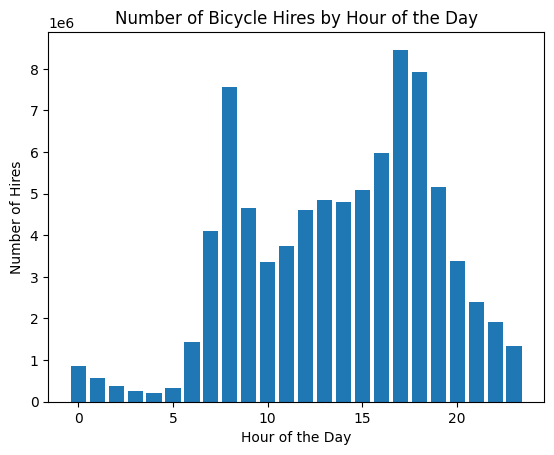

In [5]:
# split date into hour part
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.html
cycle_hire_bf['start_hour'] = cycle_hire_bf['start_date'].dt.hour
# count numberr of rows in group, e.g. rows in this start hours
# https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.size.html
hourly_hires = cycle_hire_bf.groupby('start_hour').size()


plt.bar(hourly_hires.index, hourly_hires.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Hires')
plt.title('Number of Bicycle Hires by Hour of the Day')